# Math & Data Science for Development Coursework


Oxford Mathematical Institute 

Hilary Term 2019 Assessment

### Imports, Data Wrangling

In [397]:
# imports etc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import geoplot as gplt
# see https://anaconda.org/conda-forge/geoplot for installation troubleshooting

import numpy as np

from shapely.geometry import Point

from cost_model import cost_from_metro, sort_df_by_list, projected
from dsd_processing import *

from accessibility import *

import seaborn as sns

%matplotlib inline

In [917]:
plt.rcParams['figure.figsize'] = [6,6]
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.unicode'] = True
extent=[0.5,10.5,10.5,0.5]

cost_cmap = "Reds"

plt.style.use('seaborn')

In [3]:
data_path = "../provided_data/"
spatial_path = "../spatial_data/"

In [4]:
# read in information, make spatial

metro = spatial_csv("medellin_metro.csv", path=data_path)
metro = metro.rename(columns={"Unnamed: 8":"Transfer_2"})

muni_pop = spatial_csv("muni_pop_ed.csv", path=data_path)
muni_names = list(muni_pop["Unnamed: 0"].values)

comunas = spatial_csv("comunas_new.csv", path=data_path)

# read in and sort municipality correctly
municip = projected(gpd.read_file(spatial_path+"municipalities"))
municip = sort_df_by_list(municip, muni_names)


# metro = spatial_csv("medellin_metro.csv")
# comunas = spatial_csv("comunas_new.csv")
employment = spatial_csv("muni_employment.csv", path=data_path, project=False)
# muni_pop = spatial_csv("muni_pop_ed.csv")

# read in separately because no header
commutes = gpd.GeoDataFrame(pd.read_csv(data_path+"comunas_commutes_new.csv", names=["start","end","flow"]))

# colombia spatial information
transporte = gpd.read_file(spatial_path+"Corredores_para_Transporte_de_Pasajeros")
borders = gpd.read_file(spatial_path+"Límite_Catastral_de__Comunas_y_Corregimientos")
# municip = gpd.read_file(spatial_path+"municipalities")

In [5]:
# scaling functions for sankey etc
def log_scale(minval, maxval):
    def scalar(val):
        val = val + abs(minval) + 1
        return np.log10(val)
    return scalar

def power_scale(minval, maxval):
    def scalar(val):
#         val = val + abs(minval) + 1
        return (val/100)**1.2
    return scalar

### Data Processing and Aggregation

In [6]:
# add info about which municips have a metro
yes_metro = list(set(metro["muni_index"]))
muni_pop = muni_pop.assign(metro = [True if x in yes_metro else False for x in muni_pop["muni_index"]])

In [7]:
# combine all municipality information into one geodataframe
muni_total = municip.merge(muni_pop, left_on="admin2RefN", right_on="Unnamed: 0")
muni_total = gpd.GeoDataFrame(muni_total)
muni_total = muni_total.set_geometry('geometry_x') # set geometry to polygons

# assign CRS
muni_total.crs = {'init' :'epsg:4326'}

In [8]:
# aggregate employment information
emp_total = employment.groupby('year', as_index=False).sum()
emp_total['muni_index'] = 0 
emp_total['municipality'] = 'TOTAL'
# employment = employment.append(emp_total, sort=True)

In [9]:
# clean up trailing characters, etc
comunas["comuna name"] = comunas["comuna name"].str.strip("' ")
comunas["municipality"] = comunas["municipality"].str.strip("' ")

# get full extent we're interested in 
b = municip.bounds
extent = (b['minx'].min(), b['maxx'].max(), b['miny'].min(), b['maxy'].max())

In [10]:
# modify commute data to visualize flows
commutes = commutes.assign(
    start_coord=list(map(lambda x: list(comunas[comunas["comuna_index"]==x].geometry)[0], commutes['start'])),
    end_coord=list(map(lambda x: list(comunas[comunas["comuna_index"]==x].geometry)[0], commutes['end'])))

In [11]:
def aggregate_commutes(commutes, comunas):
    """
    Aggrates commute flow information from comuna to municipality level.

    """
    # include municipality index for start/end (aggregation)
    commutes = commutes.assign(
        start_muni=list(map(lambda x: list(comunas[comunas["comuna_index"]==x]["muni_index"])[0], commutes['start'])),
        end_muni=list(map(lambda x: list(comunas[comunas["comuna_index"]==x]["muni_index"])[0], commutes['end'])))
    
    # aggregate municipality information
    commutes_muni = commutes.groupby(['start_muni','end_muni'], as_index=False).sum()
    commutes_muni = commutes_muni.drop(columns=['start','end'])
    
    return commutes_muni

In [13]:
commutes_muni = aggregate_commutes(commutes, comunas)

## Exploratory Analysis

### Plots & Maps

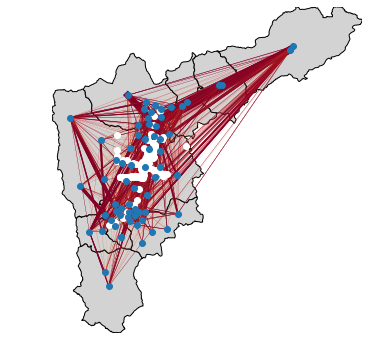

In [14]:
# quick plot of comunas information

fig, ax = plt.subplots()
ax.set_aspect('equal')
municip.plot(ax=ax, color='lightgrey', zorder=1, edgecolor='black')
gplt.sankey(commutes,start="start_coord", end="end_coord", scale="flow", scale_func=power_scale,hue="flow", cmap='YlOrRd', ax=ax, extent=extent,zorder=2)
# borders.plot(ax=ax, edgecolor='black')
# transporte.plot(ax=ax, color='grey') # all lines, including planned
transporte[transporte["ESTADO"]=="Existente"].plot(ax=ax, color='white',zorder=3) # only existing lines
# comunas.plot(column = "muni_index",ax=ax, cmap="tab10",zorder=10)
comunas.plot(ax=ax,zorder=10)
metro.plot(ax=ax, color='white',zorder=5)

plt.show();

Text(0.5, 1.0, 'Total Population')

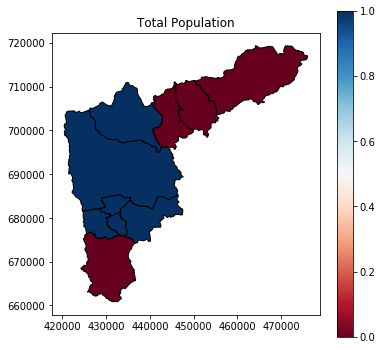

In [15]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
muni_total.plot(ax=ax, column='metro', cmap='RdBu',legend=True, edgecolor='black')
plt.title("Total Population")

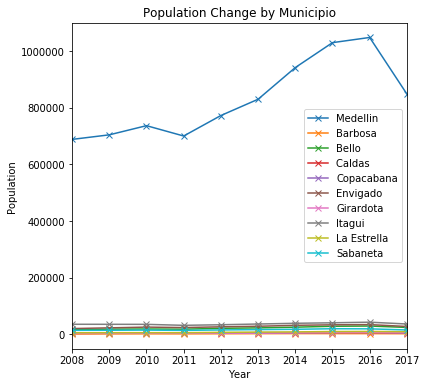

In [17]:
# population change figure
fig, ax = plt.subplots()

for i in range(1,11):
    plt.plot(employment[employment['muni_index']==i][['year']],\
             employment[employment['muni_index']==i][['employment']], \
             '-x',\
             label = list(employment[employment['muni_index']==i]['municipality'])[0])

             
plt.ylabel('Population')
        
plt.xlabel("Year")
plt.xticks(list(range(2008,2018)))
plt.xlim([2008,2017])

plt.title("Population Change by Municipio")

plt.legend()

## Cost Modelling
This section contains information about how the accessibility cost (i.e. time to get from one place to another) was calculated.

In [18]:
# estimated speed in minutes per meter
transit_speed = {"Metro": 1/1600, "Cable": 1/1600, 
                 "Tramway":1/1000, "Bus rapid transit": 1/400, 
                 "Walk": 1/84} 

transit_wait = {"Metro": 1, "Cable": 2.5, "Tramway":2.5, "Bus rapid transit": 5} #minutes

In [848]:
c = cost_from_metro(metro, municip, 
                       speed=transit_speed, 
                       wait=transit_wait, 
                       comunas=comunas)

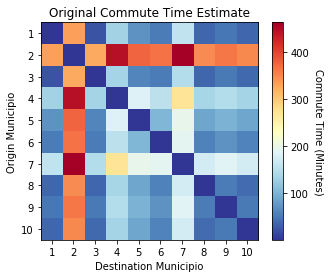

In [455]:
# transit cost from municipality to municipality in minutes
fig, ax = plt.subplots(1, figsize=(5,4), )
plt.imshow(c, extent=extent, cmap=cost_cmap)
plot_adj(ax)

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Commute Time (Minutes)', rotation=270)
plt.title("Original Commute Time Estimate")
plt.show()

## Flow Models
See Piovani et al (2018)

In [20]:
# extract employment vector, for ease
E = np.array(employment[employment["year"]==2017]["employment"])[0:10]
# similarly extract population vector
P = np.array(muni_pop["Estimated population (2018)"])

In [21]:
# TODO: HOW TO SET???
beta = 0.99

### Gravity: Single Constraint

In [109]:
def gravity_single(c, E, P, beta):
    """
    Computes an accessibility matrix based on 
    c: cost matrix (where cij is cost from i to j)
    E: employment
    P: population
    beta: parameter
    """
    
    # initialize z, which must be solved for
    Z = [np.nan] * 10 # initialize to nan
    # compute zi
    for i in range(len(Z)):
        Z[i] = 1/(sum(E*np.exp(-1*beta*c[i,:])))
        
    # initialize tij
    Tsing = np.full((10,10),np.nan)
    
    # calculate tij 
    # nb i know there's a better way but this way i don't get confused
    for i in range(10):
        for j in range(10):
            Tsing[i,j] = Z[i]*P[i]*E[j]*np.exp(-1*beta*c[i,j])
            
    return Tsing,Z   

In [219]:
Tsing,Z = gravity_single(c, E, P, 0.045)
print(Z)

[1.199883898800275e-06, 0.00038523701437101867, 2.9631802491561464e-06, 0.00013052557932265646, 2.4698906078293256e-05, 9.305057097372916e-06, 0.00015198943527341594, 4.9739926043266904e-06, 9.80802243417667e-06, 5.525501353779344e-06]


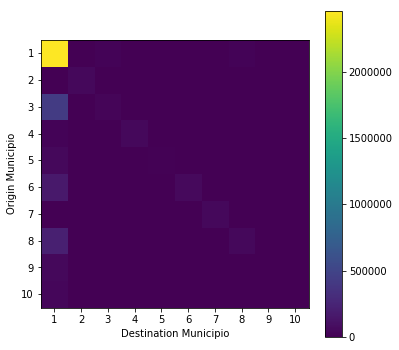

In [221]:
# fig, ax = plt.subplots()
# extent=[0.5,10.5,10.5,0.5]
# plt.imshow(Tsing, extent=extent)
# plot_adj(ax)
# plt.colorbar()
# plt.show()

### Gravity: Double Contraint

In [284]:
beta=0.05

In [285]:
def gen_tdbl(x, E, P, beta=beta, **kwargs):
    """
    Computes matrix Tdbl based on inputs
    where x is the vector being minimized
    """
    
    n = int(x.size/2)
    Tdbl = np.full((n,n),np.nan)
    
    A = x[0:n] # extract just a
    B = x[n:] # extract just b
    
    # calculate tij
    for i in range(10):
        for j in range(10):
            Tdbl[i,j] = A[i]*B[j]*P[i]*E[j]*np.exp(-1*beta*c[i,j]) 
            
            
    return Tdbl

In [299]:
def eq_constraint(x, E=E, P=P, beta=beta, **kwargs):
    """
    Computes the two norm of the difference between our guess 
    and known values for puplation and employment.
    """
    
    Tdbl = gen_tdbl(x, E, P, beta, **kwargs)
    employment_penalty = np.linalg.norm(np.sum(Tdbl, axis=0) - E)
    population_penalty = np.linalg.norm(np.sum(Tdbl, axis=1) - P)
    
    return employment_penalty + population_penalty

In [304]:
# CALCULATE A,B USING NONLINEAR OPTIMIZATION SCHEME
def objective(x, E=E, P=P, beta=beta, **kwargs):
    """
    Computes the two norm of the difference between our guess
    (essentially forces convergence)
    """
    
    return np.linalg.norm(x - update_c(x))

def update_c(x,**kwargs):
    """
    Computes a new value of c=[A,B] given a guess of c
    """
    
    A = x[0:int(x.size/2)] # extract just a
    B = x[int(x.size/2):] # extract just b
    
    a = compute_a(B,**kwargs)
    b = compute_b(A,**kwargs)
    
    return np.concatenate((a,b))
    
def compute_a(B,E=E,c=c,beta=beta,**kwargs):
    """
    Computes values of A given values for B
    """
    a = np.zeros(len(B))
    for i in range(len(B)):
        a[i] = 1/(sum(B*E*np.exp(-1*beta*c[i,:]))) 
    return a

def compute_b(A,P=P,c=c,beta=beta,**kwargs):
    """
    Computes values of B given values for A
    """
    b = np.zeros(len(A))
    for j in range(len(A)):
        b[j] = 1/(sum(A*P*np.exp(-1*beta*c[:,j]))) 
        
    return b

def gravity_double(c, E, P, beta=beta):
    """
    Uses the doubly constrained gravity model to estimate accessibility 
    using cost matrix c
    
    c: cost matrix (where cij is cost from i to j)
    E: employment
    P: population
    beta: parameter (if in doubt use beta = 0.05)
    """
    
    n = len(c)
    
    # initialize A, B to ones
    A = np.ones(n)
    B = np.ones(n)
    
    # initialize tij
    C = np.concatenate((A,B))
    
#     args = (E, P, beta)
    
    # apply minimization routine
    bnds = ((0, None), (0, None), (0, None), (0, None), (0, None), 
            (0, None), (0, None), (0, None), (0, None), (0, None),
            (0, None), (0, None), (0, None), (0, None), (0, None), 
            (0, None), (0, None), (0, None), (0, None), (0, None))
    
    # equality constraints
    cons = ({'type':'eq','fun':eq_constraint})
    
    # todo: more suscinct way of finding bounds?
    C = minimize(objective, C, tol=1e-4, bounds=bnds, constraints=cons)
    print(C)
    
    Tdbl = gen_tdbl(C.x, E, P, beta)
            
    return Tdbl,C

In [305]:
Tdbl,C = gravity_double(c, E, P, 0.05)

     fun: 0.11551616782540679
     jac: array([1.68110909e+00, 2.31963890e-02, 3.21728621e-01, 1.07385125e-03,
       3.92254377e-02, 1.48063149e-01, 3.66997849e-02, 1.95813054e-01,
       3.60392151e-01, 7.43408045e-02, 2.53011221e-02, 4.75970929e-01,
       1.14407933e-01, 3.99793368e-02, 1.53023232e-01, 1.50503062e-01,
       4.04470191e-01, 1.30426183e-01, 8.68500274e-01, 4.06135831e-01])
 message: 'Iteration limit exceeded'
    nfev: 2370
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([0.00117232, 0.08843237, 0.00124555, 0.03391962, 0.00703152,
       0.001475  , 0.04610356, 0.00104184, 0.00135923, 0.00070131,
       0.0005108 , 0.00451478, 0.01369632, 0.0048391 , 0.01918849,
       0.01905373, 0.00396499, 0.01619022, 0.10286117, 0.04847608])


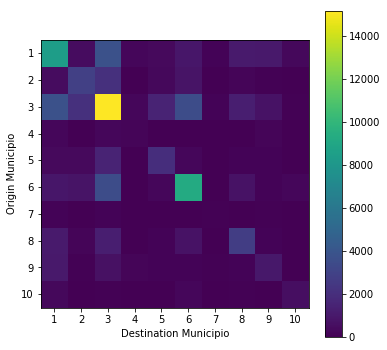

In [166]:
arr = Tobs
fig, ax = plt.subplots()
extent=[0.5,10.5,10.5,0.5]
plt.imshow(arr, extent=extent)#, norm=LogNorm(vmin=np.amin(arr),vmax=np.amax(arr)))
plot_adj(ax)
plt.colorbar()
plt.show()

### Radiation Model

In [117]:
def radiation(c, E, P, **kwargs):
    """
    Apply radiation model to cost matrix cij to get estimated flows
    
    c: cost matrix (where cij is cost from i to j)
    E: employment
    P: population
    """
    
    n = len(c)
    
    # initialize empty matrix
    E_mat = np.full((n,n),0)
    
    # compute available opportunities by looking at what is reachable 
    # from a given starting point
    for i in range(n):
        for j in range(n):
            c1 = c[i,j] # comparison travel time of interest
            in_range = (c[i,:] <= c1) # filter indices within travel time 
            E_mat[i,j] = sum(E[in_range]) # add up population
            
    # initialize tij
    Trad = np.full((n,n),np.nan)
    
    # compute!
    for i in range(10):
        for j in range(10):
            Trad[i,j] = ((P[i]/(1-P[i]/P.sum()))*((E[i]*E[j])/
                        ((E[i] + E_mat[i,j])*(E[i]+E[j]+E_mat[i,j]))))
            
    return Trad

In [307]:
Trad = radiation(c, E, P)

### Flow Comparison

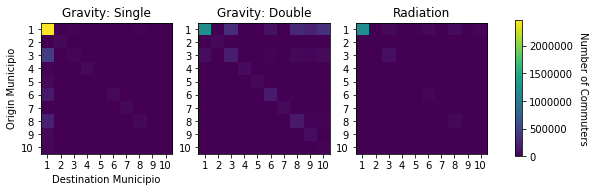

In [490]:
# three method comparitive visualization
norm = 1
methods=[Tsing*norm,Tdbl*norm,Trad*norm]
m_labels = ["Gravity: Single", "Gravity: Double", "Radiation"]

_min, _max = np.amin(methods), np.amax(methods)
n= len(methods)

fig, ax = plt.subplots(nrows=1, ncols=n, figsize=([n*3+1,2.5]))
extent=[0.5,10.5,10.5,0.5]

for i in range(n):
    cbarimg = ax[i].imshow(methods[i], extent=extent,
                           vmin=_min, vmax=_max)#, 
#                            cmap="nipy_spectral")
    if i ==0:
        plot_adj(ax[i],m_labels[i])
    else:
        plot_adj(ax[i],m_labels[i], labels=False)
    

cbar = fig.colorbar(cbarimg,ax=ax.ravel().tolist())
# TODO: FIX COLOR BAR LABELING (want: thousands)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Number of Commuters', rotation=270)

# plt.show()
plt.savefig("../figs/flow_comparison2", dpi=300)

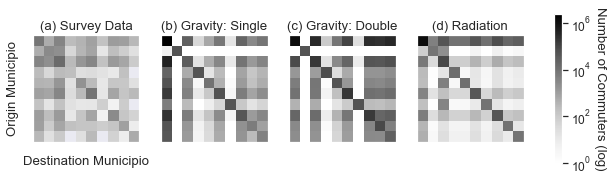

In [844]:
# three method comparitive visualization
norm = 1
methods=[Tobs,Tsing*norm,Tdbl*norm,Trad*norm]
m_labels = ["(a) Survey Data","(b) Gravity: Single", "(c) Gravity: Double", "(d) Radiation"]

_min, _max = np.amin(np.array(methods))+1, np.amax(np.array(methods))
# _min, _max = None, None
n= len(methods)

fig, ax = plt.subplots(nrows=1, ncols=n, figsize=([n*2.75,2.75]))
extent=[0.5,10.5,10.5,0.5]

# plt.subplots_adjust(wspace=0, hspace=0)

for i in range(n):
    cbarimg = ax[i].imshow(methods[i], extent=extent,
                           vmin=_min, vmax=_max, norm=LogNorm(vmin=_min,vmax=_max),
                          cmap="Greys")
#                            cmap="nipy_spectral")

    if i ==0:
        plot_adj(ax[i])
        
#     else:
#         plot_adj(ax[i],m_labels[i], labels=False)
    ax[i].grid(False)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_title(m_labels[i])

cbar = fig.colorbar(cbarimg,ax=ax.ravel().tolist())
# TODO: FIX COLOR BAR LABELING (want: thousands)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Number of Commuters (log)', rotation=270)
# plt.tight_layout()
# plt.show()
plt.savefig("../figs/flow_comparison3", dpi=300)

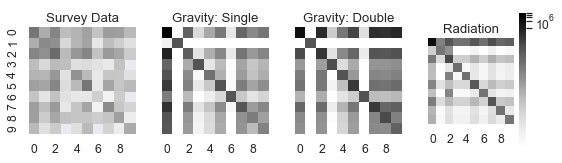

In [788]:
# three method comparitive visualization
norm = 1
methods=[Tobs,Tsing*norm,Tdbl*norm,Trad*norm]
m_labels = ["Survey Data","Gravity: Single", "Gravity: Double", "Radiation"]

_min, _max = np.amin(np.array(methods))+1, np.amax(np.array(methods))
# _min, _max = None, None
n= len(methods)

fig, ax = plt.subplots(nrows=1, ncols=n, figsize=([n*2,2.5]), sharey=True)
extent=[0.5,10.5,10.5,0.5]

plt.subplots_adjust(wspace=0, hspace=0)

for i in range(n-1):
    cbarimg = sns.heatmap(methods[i],  ax=ax[i], square=True,
                           vmin=_min, vmax=_max, norm=LogNorm(vmin=_min,vmax=_max),
                          cmap="Greys", cbar=False)
    ax[i].set_title(m_labels[i])

i = n-1
sns.heatmap(methods[i],  ax=ax[i], square=True,
                           vmin=_min, vmax=_max, norm=LogNorm(vmin=_min,vmax=_max),
                          cmap="Greys", cbar=True)
ax[i].set_title(m_labels[i])

plt.tight_layout()
plt.show()
# plt.savefig("../figs/flow_comparison2", dpi=300)

# sns.heatmap(np.transpose([candidate_summary["Track Length"].values]), ax=ax[0], square=True,
#            annot=True, fmt=".0f", alpha=0, annot_kws={"color":"black"}, cbar=False,
# #             cbar_kws={"orientation":"horizontal"},
#            xticklabels= [""], yticklabels=candidate_comunas)

### Rescaling Flow Survey Data
Flow survey data provided from 2017 was NOT appropriately normalized, and thus cannot be compared to flow predictions for other models.  To mitigate that concern, we investigate two (three?) different ways of rescaling the flow data.  We are trying to rescale flow data to be consistent with the values below:

In [36]:
# expected sum should be around
expected_pop = muni_pop["Estimated population (2018)"].sum()
expected_emp = employment[employment["year"]==2017]["employment"].sum()
print("Population total: {} ".format(expected_pop))
print("Employed individuals total (i.e. commuter total): {}".format(expected_emp))

Population total: 3909676 
Employed individuals total (i.e. commuter total): 984725


In [47]:
def observed_flow(commutes_muni, flow_col = "flow" , **kwargs):
    """
    Extracts matrix of observed survey flow aggregated at muni level
    """

    return pd.pivot_table(commutes_muni, values=flow_col, 
                          index="start_muni", columns="end_muni", 
                          fill_value=0).values

In [50]:
Tobs = observed_flow(commutes_muni)

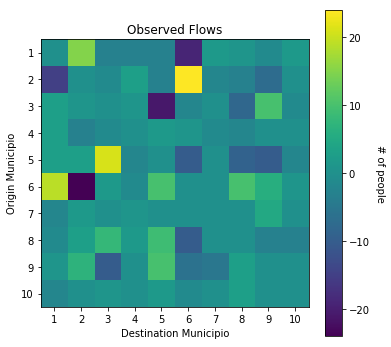

In [178]:
fig, ax = plt.subplots()
extent=[0.5,10.5,10.5,0.5]
plt.imshow(Tobs-np.transpose(Tobs), extent=extent)
plot_adj(ax, "Observed Flows")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('# of people', rotation=270)
plt.show()

#### Method 1: Scale to meet employment constraint.

In [169]:
def scale_commute_to_employment(commutes_muni, employment):
    """
    Creates numpy array corresponding to flows scaled to meet employment constraints
    specified by "employment"
    """
    
    # get observed flows
    Tobs = observed_flow(commutes_muni)
    com_tot = Tobs.sum(axis=0) # total flow INTO each area (i.e. employment)
    
    # compute scale factors for each municipality
    com_sf = [0] * 10
    com_exp = np.array([list(employment[(employment["muni_index"]==i) & 
                                        (employment["year"]==2017)]['employment'])[0] 
                        for i in range(1,11)])
    com_sf = com_exp/com_tot

    # there has to be a matrix way of doing this
    for i in range(10):
        Tobs[:,i] = com_sf[i]*Tobs[:,i]
    
    return Tobs

In [170]:
Tobs_emp = scale_commute_to_employment(commutes_muni, employment)

#### Method 2: Scale to meet population constraint.

Notes: doesn't seem to work with the unemployment data from OECD, though it works ok with fudged data.  Best backup plan.

In [172]:
def scale_commute_to_pop(commutes_muni, P, employment_rate=0.627):
    """
    Creates numpy array corresponding to flows scaled to meet employment constraints
    specified by "employment"
    """
    
    # get observed flows
    Tobs = observed_flow(commutes_muni)
    com_tot = Tobs.sum(axis=1) # total flow OUT OF each area
    
    # compute scale factors for each municipality
    com_sf = (employment_rate*P)/com_tot

    # there has to be a matrix way of doing this
    for i in range(10):
        Tobs[i,:] = com_sf[i]*Tobs[i,:]
    
    return Tobs

In [173]:
Tobs_pop = scale_commute_to_pop(commutes_muni, P, employment_rate=0.627)

#### Method 3: Nonlinear Optimization; Doubly Constrained (TODO)

(is there a way we can meet both of these constraints at the same time?) should take into account proportion of population that works ie from https://stats.oecd.org/Index.aspx?DatasetCode=LFS_SEXAGE_I_R

In [ ]:
def rescale_obj(x, obs=Tobs, pop=P, emp=E, emp_rate=employment_rate, alpha=1, beta=10, **kwargs):
    """
    Computes the two norm of the difference between our guess 
    
    obs - square array of observations
    """
    
    w1 = x[0:int(len(x)/2)] # weights for endpoints (employment)
    w2 = x[int(len(x)/2):] # weights for start points (population)
    
    wmat = np.outer(w1,w2)
    pred_emp = np.sum(wmat*Tobs, axis=0) # multiply then sum down row
    pred_pop = np.sum(wmat*Tobs, axis=1) # sum down column
    
    # NOTE: this increase in alpha value for employment is just 
    # to ensure population doesn't dominate - NOT RIGOROUS :/
    return (beta*(np.linalg.norm(emp-pred_emp)**(alpha)) + 
            (np.linalg.norm(emp_rate*pop-pred_pop))**alpha)

In [ ]:
# x = np.linspace(0,20,20)

# w1 = x[0:int(len(x)/2)] # weights for endpoints (employment)
# w2 = x[int(len(x)/2):] # weights for start points (population)

# wmat = np.outer(w1,w2)

# pred_emp = np.sum(wmat*Tobs, axis=0) # multiply then sum down row
# pred_pop = np.sum(wmat*Tobs, axis=1)

In [ ]:
# initial guess: all ones
x0 = np.ones(20)

In [ ]:
# apply minimization routine
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None), 
        (0, None), (0, None), (0, None), (0, None), (0, None),
        (0, None), (0, None), (0, None), (0, None), (0, None), 
        (0, None), (0, None), (0, None), (0, None), (0, None))
# todo: more suscinct way of finding bounds?
D = minimize(rescale_obj, x0, tol=1e-4, bounds=bnds)

In [ ]:
D = D.x

In [ ]:
# rescale tobs matrix
w1 = D[0:int(len(D)/2)] # weights for endpoints (employment)
w2 = D[int(len(D)/2):] # weights for start points (population)

wmat = np.outer(w1,w2)
Tobs_orig = Tobs # save original
Tobs3 = wmat*Tobs

In [ ]:
# rescale flows as constrained to inflows
commutes_muni["scaled_flow3"]=0 # create column
# add back into commutes_muni dataframe for later use (maybe)
for i in range(10):
    for j in range(10):
        commutes_muni.loc[((commutes_muni["start_muni"]==i) & 
                           (commutes_muni["end_muni"] ==5)),"flow"] = Tobs3[i,j]

In [ ]:
# view differences between rescaled and actual data
plt.subplots(figsize=(10,4))
plt.subplot(121)
plt.bar(muni_names,(E-np.sum(Tobs3,axis=0))/E)
plt.xticks(muni_names,muni_names,rotation=45,horizontalalignment="right")
plt.ylabel("% Difference from Census Data")
plt.title("Employment")

plt.subplot(122)
plt.bar(muni_names,(employment_rate*P-np.sum(Tobs3,axis=1))/(employment_rate*P))
plt.xticks(rotation=45,horizontalalignment="right")
plt.title("Population")

plt.show()

idea: use method similar to A,B determination above to iteratively solve for these weights

### Visual Flow Comparison

In [381]:
# combine data to set scaling the same for all models
combined_data = np.array([Tobs,Tobs1,Tobs2,Tobs3])
# _min, _max = np.amin(combined_data), np.amax(combined_data)
_min, _max = None, None

# compare observed (actual) vs observed (corrected)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,3))
extent=[0.5,10.5,10.5,0.5]

axes[0].imshow(Tobs, vmin=_min, vmax=_max, extent=extent)
axes[0].set_title("Original")
axes[0].set_xticks(list(range(1,11)))
axes[0].set_yticks(list(range(1,11)))
axes[0].set_xlabel("Destination Municipio")
axes[0].set_ylabel("Origin Municipio")

axes[1].imshow(Tobs1, vmin=_min, vmax=_max, extent=extent)
axes[1].set_title("Employment Constrained")
axes[1].set_xticks(list(range(1,11)))
axes[1].set_yticks(list(range(1,11)))

axes[2].imshow(Tobs2, vmin=_min, vmax=_max, extent=extent)
axes[2].set_title("Population Constrained")
axes[2].set_xticks(list(range(1,11)))
axes[2].set_yticks(list(range(1,11)))

cbarimg = axes[3].imshow(Tobs3, vmin=_min, vmax=_max, extent=extent)
axes[3].set_title("Doubly Constrained")
axes[3].set_xticks(list(range(1,11)))
axes[3].set_yticks(list(range(1,11)))

cbar = plt.colorbar(cbarimg, ax=axes.ravel().tolist())
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('# of people', rotation=270)

plt.show()

NameError: name 'Tobs1' is not defined

In [34]:
# combine data to set scaling the same for all models
combined_data = np.array([Tsing,Tdbl,Trad,Tobs_orig])
_min, _max = np.amin(combined_data), np.amax(combined_data)
_min,_max=None,None # leave as none to have each one on its own scale DEBUG ONLY

# TODO: CLEAN THIS UP

# plot each one in a subplot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,3))

axes[0].imshow(Tsing, vmin=_min, vmax=_max, extent=[1,10,10,1])
axes[0].set_title("Gravity: Single")
axes[0].set_xticks(list(range(1,11)))
axes[0].set_yticks(list(range(1,11)))
axes[0].set_xlabel("Destination Municipio")
axes[0].set_ylabel("Origin Municipio")

axes[1].imshow(Tdbl, vmin=_min, vmax=_max, extent=[1,10,10,1])
axes[1].set_title("Gravity: Double")
axes[1].set_xticks(list(range(1,11)))
axes[1].set_yticks(list(range(1,11)))

axes[2].imshow(Trad, vmin=_min, vmax=_max, extent=[1,10,10,1])
axes[2].set_title("Radiation")
axes[2].set_xticks(list(range(1,11)))
axes[2].set_yticks(list(range(1,11)))

cbarimg = axes[3].imshow(Tobs_orig, vmin=_min, vmax=_max, extent=[1,10,10,1])
axes[3].set_title("Observed")
axes[3].set_xticks(list(range(1,11)))
axes[3].set_yticks(list(range(1,11)))

cbar = plt.colorbar(cbarimg, ax=axes.ravel().tolist())
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('# of people', rotation=270)

plt.show()

NameError: name 'Trad' is not defined

Note: tobs is not strictly symmetric, but it is close (sketchy???) TODO make note of in report

## Accessibility Models

In [398]:
# run for each flow model
aobs = access1(Tobs,c)
asing = access1(Tsing,c)
adbl = access1(Tdbl,c)
arad = access1(Trad,c)

# run model agnostic version
a2 = access2(E,c)

In [394]:
# combine into single data frame for visualization
df = pd.DataFrame(np.transpose([aobs,asing,adbl,arad]),
                  columns=["Observed","GSingle","GDouble","Radiation"],
                  dtype="float64")
df["Muni"] = muni_names

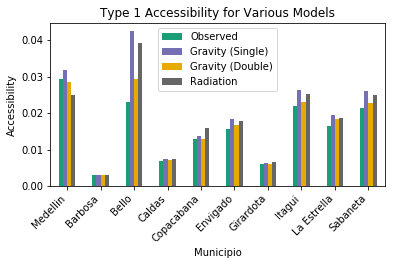

In [427]:
# side by side bar plot
fig, ax = plt.subplots(figsize=(6,3))
df.plot.bar(ax=ax, cmap='Dark2')

ax.legend(["Observed", "Gravity (Single)", "Gravity (Double)", "Radiation"])

plt.xticks(range(10),muni_names, rotation=45,horizontalalignment="right")
plt.xlabel("Municipio")
plt.ylabel("Accessibility")
plt.title("Type 1 Accessibility for Various Models")

plt.show()

In [ ]:
# TODO: compare accessibility RANK before and after intervention for each model

In [ ]:
# TODO: examine increase with additional stops
plt.bar(muni_names,access2(E,c))
plt.xticks(rotation=45,horizontalalignment="right")
plt.show()

### New Cost Matrices for Interventions

In [412]:
metro_caldas_urban = spatial_csv("medellin_metro_caldas_urban.csv", path=data_path)
c_caldas_urban = cost_from_metro(metro_caldas_urban, municip, 
                       speed=transit_speed, 
                       wait=transit_wait, 
                       comunas=comunas)

metro_caldas_rural = spatial_csv("medellin_metro_caldas_rural.csv", path=data_path)
c_caldas_rural = cost_from_metro(metro_caldas_rural, municip, 
                       speed=transit_speed, 
                       wait=transit_wait, 
                       comunas=comunas)

In [547]:
aobs_caldas_u = access1(Tobs,c_caldas_urban)
aobs_caldas_r = access1(Tobs,c_caldas_rural)

asing_caldas_u = access1(Tsing,c_caldas_urban)
asing_caldas_r = access1(Tsing,c_caldas_rural)

adbl_caldas_u = access1(Tdbl,c_caldas_urban)
adbl_caldas_r = access1(Tdbl,c_caldas_rural)

arad_caldas_u = access1(Trad,c_caldas_urban)
arad_caldas_r = access1(Trad,c_caldas_rural)

a2_caldas_u = access2(E, c_caldas_urban)
a2_caldas_r = access2(E, c_caldas_rural)

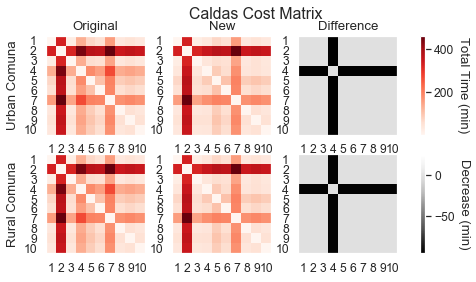

In [802]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,4))#, sharey=True,sharex=True)

_min = np.amin([c, c_caldas_urban, c_caldas_rural])
_max = np.amax([c, c_caldas_urban, c_caldas_rural])

_mind = np.amin([c_caldas_urban-c, c_caldas_rural-c])
_maxd = np.amax([c_caldas_urban-c, c_caldas_rural-c])+25

axes[0,0].grid(False)
axes[0,1].grid(False)
axes[0,2].grid(False)
axes[1,0].grid(False)
axes[1,1].grid(False)
axes[1,2].grid(False)

axes[0,0].imshow(c, extent=extent, vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[0,0], labels=False)
axes[0,0].set_title("Original")
axes[0,0].set_ylabel("Urban Comuna")

axes[0,1].imshow(c_caldas_urban,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[0,1], labels=False)
axes[0,1].set_title("New")

axes[0,2].imshow(c_caldas_urban-c,extent=extent, cmap="Greys_r",
                vmin=_mind, vmax=_maxd)
plot_adj(axes[0,2], labels=False)
axes[0,2].set_title("Difference")

axes[1,0].imshow(c,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[1,0], labels=False)
overall = axes[1,1].imshow(c_caldas_rural,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[1,1], labels=False)
diff = axes[1,2].imshow(c_caldas_rural-c,extent=extent, cmap="Greys_r",
                vmin=_mind, vmax=_maxd)
plot_adj(axes[1,2], labels=False)

axes[1,0].set_ylabel("Rural Comuna")

# colorbar for overall travel time ("Cost")
cbar = fig.colorbar(overall,ax=axes[0,:].ravel().tolist())
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Total Time (min)', rotation=270)

# colorbar for improvement/difference matrix
cbard = fig.colorbar(diff,ax=axes[1,:].ravel().tolist())
cbard.ax.get_yaxis().labelpad = 15
cbard.ax.set_ylabel('Decrease (min)', rotation=270)


fig.suptitle("Caldas Cost Matrix")

plt.savefig("../figs/caldas_cost_comparison", dpi=300)
plt.show()

In [421]:
caldas_comparison = pd.DataFrame(np.transpose([asing, asing_caldas_u, asing_caldas_r]), 
                               columns=["Original", "Caldas-Urban", "Caldas-Rural"],
                               dtype="float64")

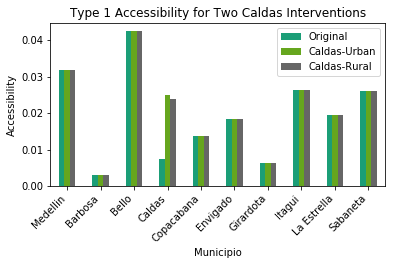

In [428]:
fig, ax = plt.subplots(figsize=(6,3))
caldas_comparison.plot.bar(ax=ax, cmap='Dark2')

ax.legend(["Original", "Caldas-Urban", "Caldas-Rural"])

plt.xticks(range(10),muni_names, rotation=45,horizontalalignment="right")
plt.xlabel("Municipio")
plt.ylabel("Accessibility")
plt.title("Type 1 Accessibility for Two Caldas Interventions")

plt.show()

In [535]:
metro_copa_urban = spatial_csv("medellin_metro_copa_urban.csv", path=data_path)
c_copa_urban = cost_from_metro(metro_copa_urban, municip, 
                       speed=transit_speed, 
                       wait=transit_wait, 
                       comunas=comunas)

metro_copa_rural = spatial_csv("medellin_metro_copa_rural.csv", path=data_path)
c_copa_rural = cost_from_metro(metro_copa_rural, municip, 
                       speed=transit_speed, 
                       wait=transit_wait, 
                       comunas=comunas)


aobs_copa_u = access1(Tobs,c_copa_urban)
aobs_copa_r = access1(Tobs,c_copa_rural)

asing_copa_u = access1(Tsing,c_copa_urban)
asing_copa_r = access1(Tsing,c_copa_rural)

adbl_copa_u = access1(Tdbl,c_copa_urban)
adbl_copa_r = access1(Tdbl,c_copa_rural)

arad_copa_u = access1(Trad,c_copa_urban)
arad_copa_r = access1(Trad,c_copa_rural)

a2_copa_u = access2(E, c_copa_urban)
a2_copa_r = access2(E, c_copa_rural)

all_copa_u = np.array([aobs_copa_u,asing_copa_u,adbl_copa_u,arad_copa_u,a2_copa_u])
all_copa_r = np.array([aobs_copa_r,asing_copa_r,adbl_copa_r,arad_copa_r,a2_copa_r])

copa_comparison = pd.DataFrame(np.transpose([asing, asing_copa_u, asing_copa_r]), 
                               columns=["Original", "copa-Urban", "copa-Rural"],
                               dtype="float64")

In [534]:
all_copa_u.shape

(5, 10)

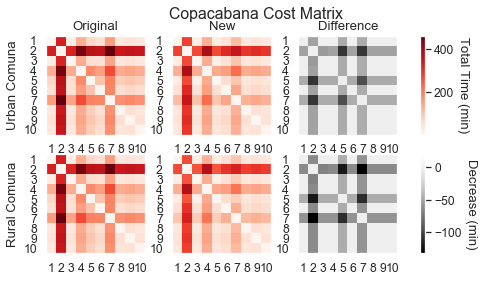

In [834]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,4))#, 
#                          sharey=True, sharex=True)

cost_cmap = "Reds"

_min = np.amin([c, c_copa_urban, c_copa_rural])
_max = np.amax([c, c_copa_urban, c_copa_rural])

_mind = np.amin([c_copa_urban-c, c_copa_rural-c])
_maxd = np.amax([c_copa_urban-c, c_copa_rural-c])+20


axes[0,0].grid(False)
axes[0,1].grid(False)
axes[0,2].grid(False)
axes[1,0].grid(False)
axes[1,1].grid(False)
axes[1,2].grid(False)

axes[0,0].imshow(c, extent=extent, vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[0,0], labels=False)
axes[0,0].set_title("Original")
axes[0,0].set_ylabel("Urban Comuna")

axes[0,1].imshow(c_copa_urban,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[0,1], labels=False)
axes[0,1].set_title("New")

axes[0,2].imshow(c_copa_urban-c,extent=extent, cmap="Greys_r",
                vmin=_mind, vmax=_maxd)
plot_adj(axes[0,2], labels=False)
axes[0,2].set_title("Difference")

axes[1,0].imshow(c,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[1,0], labels=False)
overall = axes[1,1].imshow(c_copa_rural,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[1,1], labels=False)
diff = axes[1,2].imshow(c_copa_rural-c,extent=extent, cmap="Greys_r",
                vmin=_mind, vmax=_maxd)
plot_adj(axes[1,2], labels=False)

axes[1,0].set_ylabel("Rural Comuna")

# colorbar for overall travel time ("Cost")
cbar = fig.colorbar(overall,ax=axes[0,:].ravel().tolist())
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Total Time (min)', rotation=270)

# colorbar for improvement/difference matrix
cbard = fig.colorbar(diff,ax=axes[1,:].ravel().tolist())
cbard.ax.get_yaxis().labelpad = 15
cbard.ax.set_ylabel('Decrease (min)', rotation=270)


fig.suptitle("Copacabana Cost Matrix")

plt.savefig("../figs/copa_cost_comparison", dpi=300)
plt.show()

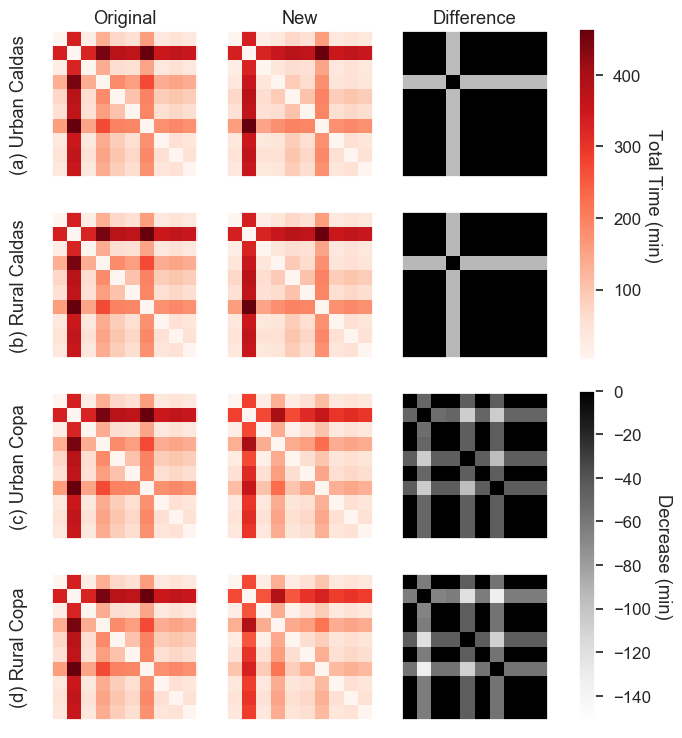

In [943]:
# MEGA COMPARISON PLOT

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8,9))#, 
#                          sharey=True, sharex=True)

cost_cmap = "Reds"
grey_cmap = "Greys"

_min = np.amin([c, c_copa_urban, c_copa_rural,c_caldas_urban, c_caldas_rural])
_max = np.amax([c, c_copa_urban, c_copa_rural,c_caldas_urban, c_caldas_rural])

_mind = np.amin([c_copa_urban-c, c_copa_rural-c,c_caldas_urban-c, c_caldas_rural-c])-20
_maxd = np.amax([c_copa_urban-c, c_copa_rural-c,c_caldas_urban-c, c_caldas_rural-c])

# CALDAS

axes[0,0].grid(False)
axes[0,1].grid(False)
axes[0,2].grid(False)
axes[1,0].grid(False)
axes[1,1].grid(False)
axes[1,2].grid(False)

axes[0,0].imshow(c, extent=extent, vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[0,0], labels=False)
axes[0,0].set_title("Original")
axes[0,0].set_ylabel("(a) Urban Caldas")

axes[0,1].imshow(c_caldas_urban,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[0,1], labels=False)
axes[0,1].set_title("New")

axes[0,2].imshow(c_caldas_urban-c,extent=extent, cmap=grey_cmap,
                vmin=_mind, vmax=_maxd)
plot_adj(axes[0,2], labels=False)
axes[0,2].set_title("Difference")

axes[1,0].imshow(c,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[1,0], labels=False)
overall = axes[1,1].imshow(c_caldas_rural,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[1,1], labels=False)
diff = axes[1,2].imshow(c_caldas_rural-c,extent=extent, cmap=grey_cmap,
                vmin=_mind, vmax=_maxd)
plot_adj(axes[1,2], labels=False)

axes[1,0].set_ylabel("(b) Rural Caldas")

# COPA
axes[2,0].grid(False)
axes[2,1].grid(False)
axes[2,2].grid(False)
axes[3,0].grid(False)
axes[3,1].grid(False)
axes[3,2].grid(False)

for i in range(4):
    for j in range(3):
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])


axes[2,0].imshow(c, extent=extent, vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[2,0], labels=False)
# axes[2,0].set_title("Original")
axes[2,0].set_ylabel("(c) Urban Copa")

axes[2,1].imshow(c_copa_urban,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[2,1], labels=False)
# axes[2,1].set_title("New")

axes[2,2].imshow(c_copa_urban-c,extent=extent, cmap=grey_cmap,
                vmin=_mind, vmax=_maxd)
plot_adj(axes[2,2], labels=False)
# axes[2,2].set_title("Difference")

axes[3,0].imshow(c,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[3,0], labels=False)
overall = axes[3,1].imshow(c_copa_rural,extent=extent,vmin=_min, vmax=_max, cmap=cost_cmap)
plot_adj(axes[3,1], labels=False)
diff = axes[3,2].imshow(c_copa_rural-c,extent=extent, cmap=grey_cmap,
                vmin=_mind, vmax=_maxd)
plot_adj(axes[3,2], labels=False)

axes[3,0].set_ylabel("(d) Rural Copa")

# colorbar for overall travel time ("Cost")
cbar = fig.colorbar(overall,ax=axes[0:2,:].ravel().tolist())
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Total Time (min)', rotation=270)

# colorbar for improvement/difference matrix
cbard = fig.colorbar(diff,ax=axes[2:4,:].ravel().tolist())
cbard.ax.get_yaxis().labelpad = 15
cbard.ax.set_ylabel('Decrease (min)', rotation=270)


# fig.suptitle("Intervention - Cost Matrix Change")

# plt.savefig("../figs/overall_cost_comparison", dpi=300)
plt.show()

In [856]:
col

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

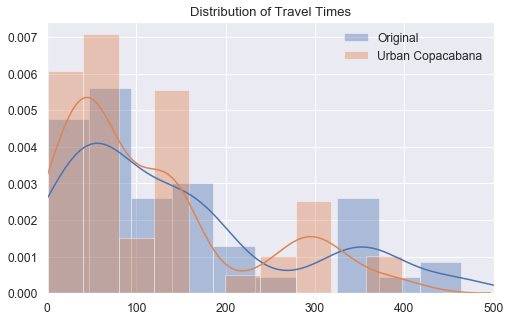

In [882]:
plt.figure(figsize=(8,5))

nbin = 10
sns.distplot(c.flatten().tolist(), label="Original", bins=nbin, hist=True)
sns.distplot(c_copa_urban.flatten().tolist(), label="Urban Copacabana", bins=nbin, hist=True)

plt.title("Distribution of Travel Times")

plt.legend(frameon=False)
plt.xlim([0,500])

plt.show()

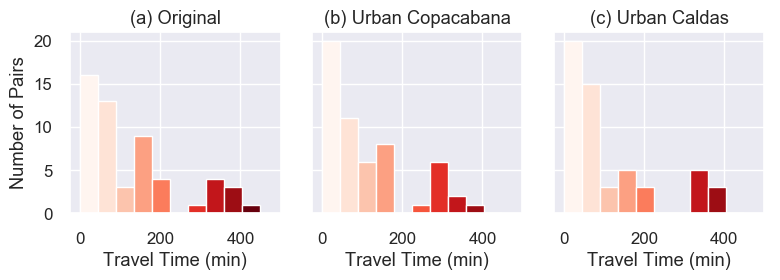

In [940]:
import matplotlib.ticker as plticker

# create histogram of costs to help debug etc, with colorscheme matching the above
nbins = 10
bin_range = (0,450)

cm = plt.cm.get_cmap(cost_cmap)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3), sharey=True)

n, bins, patches = axes[0].hist(c[np.triu_indices(10)].flatten().tolist(), nbins, range=bin_range)
n1, bins1, patches1 = axes[1].hist(c_copa_urban[np.triu_indices(10)].flatten().tolist(), nbins, range=bin_range)
n2, bins2, patches2 = axes[2].hist(c_caldas_urban[np.triu_indices(10)].flatten().tolist(), nbins, range=bin_range)


bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)


bin_centers1 = 0.5 * (bins1[:-1] + bins1[1:])
# scale values to interval [0,1]
col1 = bin_centers1 - min(bin_centers1)

bin_centers2 = 0.5 * (bins2[:-1] + bins2[1:])
# scale values to interval [0,1]
col2 = bin_centers2 - min(bin_centers2)

col /= np.amax([col,col1,col2])
col1 /= np.amax([col,col1,col2])
col2 /= np.amax([col,col1,col2])

for column, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(column))
    
for column, p in zip(col1, patches1):
    plt.setp(p, 'facecolor', cm(column))
    
for column, p in zip(col2, patches2):
    plt.setp(p, 'facecolor', cm(column))
    
axes[0].set_xlabel("Travel Time (min)")
axes[1].set_xlabel("Travel Time (min)")
axes[2].set_xlabel("Travel Time (min)")

axes[0].set_ylabel("Number of Pairs")

axes[0].set_title("(a) Original")
axes[1].set_title("(b) Urban Copacabana")
axes[2].set_title("(c) Urban Caldas")

xlim= [-25,500]
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[2].set_xlim(xlim)

# axes[0].set_ylim([0,20])
axes[0].yaxis.set_major_locator(plticker.MultipleLocator(5))

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.tight_layout()

plt.savefig("../figs/travel_time_comparison.png", dpi=300)

plt.show()


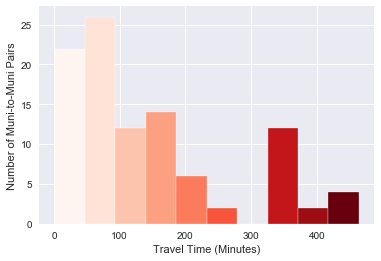

In [910]:
# create histogram of costs to help debug etc, with colorscheme matching the above
nbins = 10

cm = plt.cm.get_cmap(cost_cmap)

fig, axes = plt.subplots(figsize=(6,4))
n, bins, patches = plt.hist(c.flatten().tolist(), nbins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for column, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(column))
    
plt.xlabel("Travel Time (Minutes)")
plt.ylabel("Number of Muni-to-Muni Pairs")
plt.show()

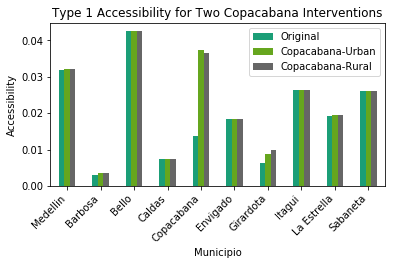

In [426]:
fig, ax = plt.subplots(figsize=(6,3))
copa_comparison.plot.bar(ax=ax, cmap='Dark2')

ax.legend(["Original", "Copacabana-Urban", "Copacabana-Rural"])

plt.xticks(range(10),muni_names, rotation=45,horizontalalignment="right")
plt.xlabel("Municipio")
plt.ylabel("Accessibility")
plt.title("Type 1 Accessibility for Two Copacabana Interventions")

plt.show()

In [913]:
candidate_comunas = ["(a) Urban Caldas", "(b) Rural Caldas", 
                     "(c) Urban Copacabana", "(d) Rural Copacabana"]

In [590]:
candidate_summary = pd.DataFrame(candidate_comunas, columns=["Comuna"])

In [665]:
candidate_metro = [metro_caldas_urban, 
                  metro_caldas_rural,
                  metro_copa_urban, 
                  metro_copa_rural]

candidate_length = [metro_caldas_urban.iloc[20].geometry.distance(metro_caldas_urban.iloc[21].geometry),
                      metro_caldas_rural.iloc[20].geometry.distance(metro_caldas_rural.iloc[21].geometry),
                      metro_copa_urban.iloc[0].geometry.distance(metro_copa_urban.iloc[1].geometry),
                      metro_copa_rural.iloc[0].geometry.distance(metro_copa_rural.iloc[1].geometry)]

candidate_summary["Track Length"] = candidate_length

In [592]:
# combine results into one array
access = np.array([[aobs_caldas_u,asing_caldas_u,adbl_caldas_u,arad_caldas_u,a2_caldas_u],
             [aobs_caldas_r,asing_caldas_r,adbl_caldas_r,arad_caldas_r,a2_caldas_r],
              [aobs_copa_u,asing_copa_u,adbl_copa_u,arad_copa_u,a2_copa_u],
             [aobs_copa_r,asing_copa_r,adbl_copa_r,arad_copa_r,a2_copa_r]])

# combine original results into one array
access_orig = np.array([aobs,asing,adbl,arad,a2])

In [593]:
# use ratio to find biggest improvement for each method
access_improvement = np.zeros(access.shape)
for j in range(len(access_orig)):
    for i in range(4):
        access_improvement[i,j] = access[i,j]/access_orig[j]

In [594]:
# get mean improvement across all municipalities
access_mean = np.mean(access_improvement,axis=2)

In [606]:
# get improvement for addressed municipality
access_intra = np.concatenate((access_improvement[0:2,:,3],access_improvement[2:4,:,4]))

In [911]:
cols = ["A1-Obs", "A1-Gsing", "A1-Gdbl", "A1-Rad", "A2"]
for j in range(len(cols)):
    candidate_summary[cols[j], "mean"] = access_mean[:,j]
    candidate_summary[cols[j], "intra"] = access_intra[:,j]

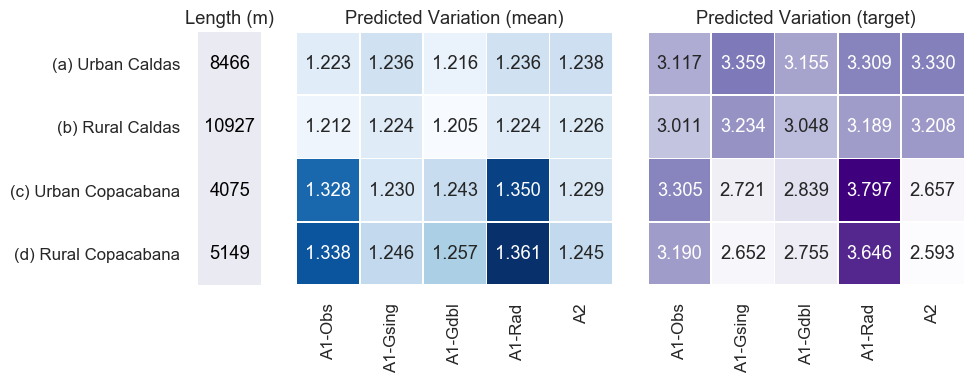

In [920]:
fig, ax = plt.subplots(1,3,sharey=True, figsize=(10,4), gridspec_kw = {'width_ratios':[1,5,5]})
sns.set(font_scale=1.1)
sns.heatmap(np.transpose([candidate_summary["Track Length"].values]), ax=ax[0], square=True,
           annot=True, fmt=".0f", alpha=0, annot_kws={"color":"black"}, cbar=False,
#             cbar_kws={"orientation":"horizontal"},
           xticklabels= [""], yticklabels=candidate_comunas)
ax[0].set_title("Length (m)")


sns.heatmap(access_mean, annot=True, fmt=".3f",cmap="Blues",square=True,
            linewidths=.5,
                xticklabels=cols, yticklabels=candidate_comunas, ax=ax[1], cbar=False)
#             cbar_kws={"orientation":"horizontal"})
ax[1].set_title("Predicted Variation (mean)")
ax[1].yaxis.set_visible(False)

sns.heatmap(access_intra,ax=ax[2], annot=True, fmt=".3f",cmap="Purples",square=True,linewidths=.5,
                xticklabels=cols, yticklabels=candidate_comunas,  cbar=False)
#             cbar_kws={"orientation":"horizontal"})
ax[2].set_title("Predicted Variation (target)")
ax[2].yaxis.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)

            
plt.tight_layout()
plt.savefig("../figs/results.png", dpi=300)
plt.show()

_______________
## Scratch


In [ ]:
# depreciated
# # initialize z
# Z = [np.nan] * 10 # initialize to nan
# # compute zi
# for i in range(len(Z)):
#     Z[i] = 1/(sum(E*np.exp(-1*beta*c[i,:])))
# initialize tij
# Tsing = np.full((10,10),np.nan)
# calculate tij 
# nb i know there's a better way but this way i don't get confused
# for i in range(10):
#     for j in range(10):
#         Tsing[i,j] = Z[i]*P[i]*E[j]*np.exp(-1*beta*c[i,j])

In [ ]:
muni_pop["Unnamed: 0"].values

In [ ]:
employment[employment["year"]==2017]["employment"].sum()

In [ ]:
com_sf

In [ ]:
# # DEPRECIATED
# # temporary cost matrix (TODO)
# c = np.random.randint(10,25,size=(10,10))
# # make proportional to distance (simple)
# for i in range(10):
#     for j in range(10):
#         if i==j:
#             c[i,j]=1
#         else:
#             c[i,j] = 1/np.sqrt((i-i)**2+(i-j)**2)
            
# # read in distance matrix from csv
# dist_mat = pd.read_csv(spatial_path + "dist_mat/dist_mat.csv")
# # match names to numbers
# for i in range(len(dist_mat)):
#     dist_mat.loc[i,"start_muni"] = int(list(muni_names).index(dist_mat.loc[i,"InputID"])+1)
#     dist_mat.loc[i,"end_muni"] = int(list(muni_names).index(dist_mat.loc[i,"TargetID"])+1)
    
# # pivot from data frame to matrix, save as cost matrix
# c = pd.pivot_table(dist_mat, values="Distance", 
#                    index="start_muni", columns="end_muni", 
#                    fill_value=0).values
# # scale to biggest value (put in interval 0-1)
# c = c/np.amax(c)

## SCRATCH Radiation Double Constraint

In [ ]:
# # initialize A, B to ones
# A = np.ones(10)
# B = np.ones(10)

In [ ]:
# initialize tij
# Tdbl = np.full((10,10),np.nan)

In [ ]:
# C = np.concatenate((A,B))

In [ ]:
# # TODO: CALCULATE A,B USING NONLINEAR OPTIMIZATION SCHEME
# def objective(x):
#     """
#     Computes the two norm of the difference between our guess 
#     """
#     return np.linalg.norm(x - update_c(x))**2

# def update_c(x,**kwargs):
#     """
#     Computes a new value of c=[A,B] given a guess of c
#     """
    
#     A = x[0:int(x.size/2)] # extract just a
#     B = x[int(C.size/2):] # extract just b
    
#     a = compute_a(B,**kwargs)
#     b = compute_b(A,**kwargs)
    
#     return np.concatenate((a,b))
    
# def compute_a(B,E=E,c=c,beta=beta,**kwargs):
#     """
#     Computes values of A given values for B
#     """
#     a = np.zeros(len(B))
#     for i in range(len(B)):
#         a[i] = 1/(sum(B[i]*E[i]*np.exp(-1*beta*c[i,:]))) 
#     return a

# def compute_b(A,P=P,c=c,beta=beta,**kwargs):
#     """
#     Computes values of B given values for A
#     """
#     b = np.zeros(len(A))
#     for i in range(len(A)):
#         b[i] = 1/(sum(A[i]*P[i]*np.exp(-1*beta*c[i,:]))) 
        
#     return b

In [ ]:
# # apply minimization routine
# bnds = ((0, None), (0, None), (0, None), (0, None), (0, None), 
#         (0, None), (0, None), (0, None), (0, None), (0, None),
#         (0, None), (0, None), (0, None), (0, None), (0, None), 
#         (0, None), (0, None), (0, None), (0, None), (0, None))
# # todo: more suscinct way of finding bounds?
# C = minimize(objective, C, tol=1e-4, bounds=bnds)

In [ ]:
# C = C.x # extract solution

In [ ]:
# A = C[0:int(C.size/2)] # extract just a
# B = C[int(C.size/2):] # extract just b

In [ ]:
# # calculate tij
# for i in range(10):
#     for j in range(10):
#         Tdbl[i,j] = A[i]*B[j]*P[i]*E[j]*np.exp(-1*beta*c[i,j]) 

## SCRATCH Radiation Model

In [ ]:
# initialize empty matrix
# E_mat = np.full((10,10),0)

In [ ]:
# # compute available opportunities by looking at what is reachable from a given starting point
# for i in range(10):
#     for j in range(10):
#         c1 = c[i,j] # comparison travel time of interest
#         in_range = (c[i,:] <= c1) # filter indices within travel time 
#         E_mat[i,j] = sum(E[in_range]) # add up population

In [ ]:
# initialize tij
# Trad = np.full((10,10),np.nan)

In [ ]:
# # compute!
# for i in range(10):
#     for j in range(10):
#         Trad[i,j] = ((P[i]/(1-P[i]/P.sum()))*((E[i]*E[j])/
#                     ((E[i] + E_mat[i,j])*(E[i]+E[j]+E_mat[i,j]))))

In [ ]:
# visualize independently
# plt.figure(figsize=(3,3))
# plt.imshow(Trad)

In [321]:
def plot_adj(axes, title="", labels=True):
    """
    Helper function to set axis, title, labels consistenly etc.
    """
    axes.set_title(title)
    axes.set_xticks(list(range(1,11)))
    axes.set_yticks(list(range(1,11)))
    if labels:
        axes.set_xlabel("Destination Municipio")
        axes.set_ylabel("Origin Municipio")

### Scratch: Scaling


In [ ]:
# TODO: what to do about zero entries in our cost matrix 
# (IE what about the diagonal? EXCLUDE or SET CIJ TO ONE)
def exclude(lst, i):
    if i == 0:
        return lst[i+1:]

    return np.concatenate((lst[:i],lst[i+1:]))

def access1(T,c):
    """
    Creates an access index of type 1 based on inputs:
        T (flow from i to j, square matrix)
        c (cost of travel from i to j, square matrix)
        
    See Piovani et al (2018) eqn 3.10
    """
    outsize = c.shape[0]
    # initialize output to nans
    A = [np.nan] * outsize
    # iterate
    for i in range(outsize):
        A[i] = sum(exclude(T[i,:],i)*(1/exclude(c[i,:],i)))/sum(exclude(T[i,:],i))
    
    return A
    
    
def access2(E,c):
    """
    Creates an accessibility index of type 2 based on inputs:
        E (opportunities/employment at each location, vector)
        c (cost of travel from i to j, square matrix)
        
    See Piovani et al (2018) eqn 3.11
    """
    outsize = c.shape[0]
    # initialize output to nans
    A = [np.nan] * outsize
    # iterate
    for i in range(outsize):
        A[i] = sum(exclude(E,i)/exclude(c[i,:],i))/outsize
        
    return A

In [ ]:
# # assume employment_rate proportion of total population is employed
# # employment_rate = 0.627 
# # TODO: PICK BETTER NUMBER HERE - this is from https://stats.oecd.org/Index.aspx?DatasetCode=LFS_SEXAGE_I_R
# # make sure you select all people, not just a specific age group
# employment_rate=0.627 # 0.5 generally seems to work (though not ideal)

In [ ]:
# # compute scale factors for each municipality
# com_sf_2 = [0] * 10
# for i in range(1,11):
#     com_tot_2 = commutes_muni[commutes_muni["start_muni"]==i]["flow"].sum()
#     com_exp_2 = employment_rate * muni_pop.loc[i-1,"Estimated population (2018)"]
#     com_sf_2[i-1] = com_exp_2/com_tot_2

In [ ]:
# # rescale flows as constrained to inflows
# commutes_muni["scaled_flow2"]=np.nan # create column

# for i in range(1,11):
#     commutes_muni.loc[commutes_muni["start_muni"]==i,
#                       "scaled_flow2"] = np.round(commutes_muni[commutes_muni["start_muni"]==i]["flow"]*com_sf_2[i-1])
    

In [ ]:
# commutes_muni["scaled_flow2"].sum()

In [ ]:
# flow_col = "scaled_flow2"
# Tobs2 = pd.pivot_table(commutes_muni, values=flow_col, index="start_muni", columns="end_muni", fill_value=0).values

In [12]:
# # include municipality index for start/end (aggregation)
# commutes = commutes.assign(
#     start_muni=list(map(lambda x: list(comunas[comunas["comuna_index"]==x]["muni_index"])[0], commutes['start'])),
#     end_muni=list(map(lambda x: list(comunas[comunas["comuna_index"]==x]["muni_index"])[0], commutes['end'])))

# # aggregate municipality information
# commutes_muni = commutes.groupby(['start_muni','end_muni'], as_index=False).sum()
# commutes_muni = commutes_muni.drop(columns=['start','end'])

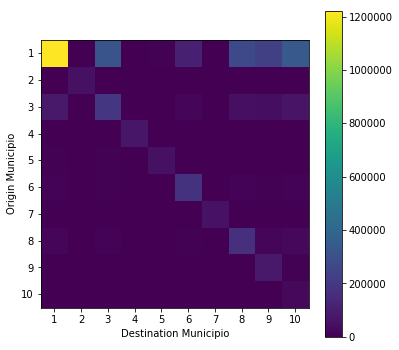

In [306]:
# from matplotlib.colors import LogNorm
# arr = Tdbl
# fig, ax = plt.subplots()
# extent=[0.5,10.5,10.5,0.5]
# plt.imshow(arr, extent=extent)#, norm=LogNorm(vmin=np.amin(arr),vmax=np.amax(arr)))
# plot_adj(ax)
# plt.colorbar()
# plt.show()

In [817]:
# for i in range(len(muni_names)):
#     print("{} & {} \\\\".format(i+1,muni_names[i]))

1 & Medellin \\
2 & Barbosa \\
3 & Bello \\
4 & Caldas \\
5 & Copacabana \\
6 & Envigado \\
7 & Girardota \\
8 & Itagui \\
9 & La Estrella \\
10 & Sabaneta \\


In [923]:
P[1]+P[6]


110416

In [922]:
muni_names


['Medellin',
 'Barbosa',
 'Bello',
 'Caldas',
 'Copacabana',
 'Envigado',
 'Girardota',
 'Itagui',
 'La Estrella',
 'Sabaneta']

In [925]:
access_improvement.shape

(4, 5, 10)